In [1]:
import wandb
import numpy as np
import random
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset
import torchvision.transforms as transforms

## Question 2

In [2]:
def read_images(path):
    """
    Read images from a folder using PyTorch's ImageFolder and DataLoader,
    apply transformations, and return NumPy arrays for images and labels.

    Args:
    - path (str): Path to the folder containing images.

    Returns:
    - X (np.array): NumPy array of images with shape (num_images, channels, height, width).
    - y (np.array): NumPy array of labels with shape (num_images,).
    """
    data_transform = transforms.Compose([transforms.Resize((227,227)), transforms.ToTensor()])
    dataset = ImageFolder(path, transform=data_transform)
        
    data = DataLoader(dataset, batch_size=32) 
    
    X = [] 
    y = []
    
    for image, label in tqdm(data):
        X.append(image) 
        y.append(label) 
        
    # Concatenate the lists of arrays along the batch dimension (axis=0)
    X = np.concatenate(X, axis=0)
    y = np.concatenate(y, axis=0)
        
    return X, y

In [3]:
def plot_image(image_matrix):
    """
    Display an image using Matplotlib.

    Parameters:
    - image_matrix (numpy.ndarray): NumPy array containing the image data. 
                                    Should be in the format (channels, height, width).

    Returns:
    None
    """
    image = image_matrix
    # Transpose the image array from (channels, height, width) to (height, width, channels) for Matplotlib
    image = np.transpose(image, (1, 2, 0))

    # Display the image using Matplotlib
    plt.imshow(image)
    plt.axis('off')  # Turn off axis labels
    plt.show()

In [4]:
def train_val_split(train_size:float = 0.2):
    """
    Split the training data into training and validation sets.

    Parameters:
    - train_size (float, optional): The proportion of the dataset to include in the validation set (default=0.2).

    Returns:
    - X_train (numpy.ndarray): NumPy array containing training images.
    - X_val (numpy.ndarray): NumPy array containing validation images.
    - y_train (numpy.ndarray): NumPy array containing training labels.
    - y_val (numpy.ndarray): NumPy array containing validation labels.
    """
    
    # Initialize lists to store validation and training data
    X_val = []
    y_val = []
    X = []
    y = []
    
    # 1000 because we have 1000 images of each class
    samples_per_class_val = (int) (1000 * train_size)
    
    for class_label in range(10):
        # extract indices corresponding to the current class
        class_indices = np.where(y_train==class_label)[0]
        
        # randomly select sample_per_class_val indices for validation
        val_indices = np.random.choice(class_indices, samples_per_class_val, replace=False)
        
        # append the selected val data to X_val and y_val
        X_val.extend(X_train[val_indices])
        y_val.extend(y_train[val_indices])
        
        # append the remaining data to X_train and y_train
        train_indices = np.setdiff1d(class_indices, val_indices)
        X.extend(X_train[train_indices])
        y.extend(y_train[train_indices])

    # convert python lists to np array
    X_val = np.array(X_val)
    y_val = np.array(y_val)
    X = np.array(X)
    y = np.array(y)
    
    return X, X_val, y, y_val

In [5]:
def shuffle_data(X, y):
    """
    Shuffle data samples and their corresponding labels.

    Parameters:
    - X (numpy.ndarray): NumPy array containing data samples.
    - y (numpy.ndarray): NumPy array containing corresponding labels.

    Returns:
    - X_shuffled (numpy.ndarray): NumPy array containing shuffled data samples.
    - y_shuffled (numpy.ndarray): NumPy array containing corresponding shuffled labels.
    """
    
    # Combine X, y into a list of tuples
    data = list(zip(X, y))

    # Shuffle the combined data
    random.shuffle(data)

    # Unpack the shuffled data back into separate arrays
    X_shuffled, y_shuffled = zip(*data)

    # Convert the shuffled lists to NumPy arrays 
    X_shuffled = np.array(X_shuffled)
    y_shuffled = np.array(y_shuffled)
    
    return X_shuffled, y_shuffled

In [6]:
def create_dataloader(X, y, batch_size, shuffle=True):
    """
    Create a PyTorch DataLoader from input data and labels.

    Parameters:
    - X (numpy.ndarray): Input data array.
    - y (numpy.ndarray): Labels array.
    - batch_size (int, optional): Batch size for DataLoader (default=32).
    - shuffle (bool, optional): Whether to shuffle the data (default=True).

    Returns:
    - DataLoader: PyTorch DataLoader for the input data and labels.
    """
    # Convert NumPy arrays to PyTorch tensors
    X_tensor = torch.from_numpy(X)
    y_tensor = torch.from_numpy(y)

    # Create a TensorDataset from X_train_tensor and y_train_tensor
    dataset = TensorDataset(X_tensor, y_tensor)

    # Define batch size and create DataLoader
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    return loader

In [7]:
def augment_data(train_loader):
    """
    Augment data in a DataLoader using various transformations and return an augmented DataLoader.

    Args:
    - train_loader (DataLoader): DataLoader containing the original training data.

    Returns:
    - aug_loader (DataLoader): Augmented DataLoader with transformed data for training.
    """
    
    # Create a copy of the original train_loader
    train_loader_copy = copy.deepcopy(train_loader)
    
    # Define data augmentation transformations
    augmented_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
        transforms.RandomRotation(10),  # Randomly rotate the image by up to 10 degrees
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly adjust brightness, contrast, saturation, and hue
        transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    ])
    
    # Apply the transformations to the images in train_loader
    train_loader_copy.dataset.transform = augmented_transform

    augmented_dataset = ConcatDataset([train_loader.dataset, train_loader_copy.dataset])
    aug_loader = DataLoader(augmented_dataset, batch_size=train_loader.batch_size, shuffle=True)
    return aug_loader

In [17]:
def accuracy_fn(y_true, y_pred):
    """
    Calculate the accuracy of predictions.

    Args:
    - y_true (Tensor): True labels.
    - y_pred (Tensor): Predicted labels.

    Returns:
    - acc (float): Accuracy percentage.
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

In [10]:
# Getting GPU access if available 

# for mac run this line 
device = "mps" if torch.backends.mps.is_available() else "cpu"

# for windows run this line
# device = "cuda" if torch.cuda.is_available() else "cpu"

def train_step(model:torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    """
    Perform a single training step on the given data.

    Args:
    - model (torch.nn.Module): The neural network model.
    - data_loader (torch.utils.data.DataLoader): DataLoader containing the training data.
    - loss_fn (torch.nn.Module): Loss function for optimization.
    - optimizer (torch.optim.Optimizer): Optimizer for updating model parameters.
    - accuracy_fn (function): Function to calculate accuracy.
    - device (torch.device): Device on which to perform computations (default is the device the model is on).

    Returns:
    - train_loss (float): Average training loss for the step.
    - train_acc (float): Average training accuracy for the step.
    """

    train_loss, train_acc = 0,0
    model.train()

    for batch, (X, y) in enumerate(data_loader):
        # put data on target device
        X, y = X.to(device), y.to(device)

        # forward pass
        y_pred = model(X)

        # calc loss (per batch) and accuracy
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        optimizer.zero_grad()

        # back pass
        loss.backward()

        # updating the parameters
        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    return train_loss, train_acc

In [11]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    
    """
    Perform a single testing step on the given data.

    Args:
    - model (torch.nn.Module): The neural network model.
    - data_loader (torch.utils.data.DataLoader): DataLoader containing the test data.
    - loss_fn (torch.nn.Module): Loss function for evaluation.
    - accuracy_fn (function): Function to calculate accuracy.
    - device (torch.device): Device on which to perform computations (default is the device the model is on).

    Returns:
    - test_loss (float): Average test loss.
    - test_acc (float): Average test accuracy.
    """

    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X_test, y_test in data_loader:
            # send data to the target device
            X_test, y_test = X_test.to(device), y_test.to(device)

            # forward pass
            test_pred = model(X_test)

            # calc loss
            test_loss += loss_fn(test_pred, y_test)

            # calc add
            test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))

        # clac the test loss avg per batch
        test_loss /= len(data_loader)

        # calc the test acc avg per batch
        test_acc /= len(data_loader)
        
        return test_loss, test_acc

# CNN Class

In [12]:
class CNN(nn.Module):
    
    """
    Convolutional Neural Network (CNN) model.

    Args:
    - in_channels (int): Number of input channels.
    - out_channels (int): Number of output channels (not used).
    - num_filters (list): List of integers specifying the number of filters for each convolutional layer.
    - kernel_size (list): List of integers specifying the kernel size for each convolutional layer.
    - activation_fn (str): Activation function to use ("ReLU", "GELU", "SiLU", "Mish").
    - apply_batchnorm (str): Whether to apply batch normalization ("Yes" or "No").
    - apply_dropout (str): Whether to apply dropout ("Yes" or "No").
    - prob (float): Dropout probability.
    - hidden_units (int): Number of units in the hidden layer.

    Attributes:
    - conv1 to conv5 (nn.Conv2d): Convolutional layers.
    - batchnorm1 to batchnorm5 (nn.BatchNorm2d): Batch normalization layers.
    - activation (nn.Module): Activation function.
    - pool (nn.MaxPool2d): Max pooling layer.
    - fc1 (nn.Linear): Dense layer.
    - dropout (nn.Dropout): Dropout layer.
    - fc2 (nn.Linear): Output layer.

    Methods:
    - forward(x): Forward pass through the network.

    Returns:
    - x (Tensor): Output tensor after softmax activation.
    """

    def __init__(self, in_channels, out_channels, num_filters, kernel_size, activation_fn, apply_batchnorm, apply_dropout, prob, hidden_units):
        super(CNN, self).__init__()
        # Define the convolution layers
        self.conv1 = nn.Conv2d(
                               in_channels=in_channels, 
                               out_channels=num_filters[0], 
                               kernel_size=kernel_size[0], 
                               stride=1, 
                               padding=0
                              )
        self.batchnorm1 = nn.BatchNorm2d(num_filters[0])
        self.conv2 = nn.Conv2d(
                               in_channels=num_filters[0],
                               out_channels=num_filters[1], 
                               kernel_size=kernel_size[1], 
                               stride=1, 
                               padding=0
                              )
        self.batchnorm2 = nn.BatchNorm2d(num_filters[1])
        self.conv3 = nn.Conv2d(
                               in_channels=num_filters[1], 
                               out_channels=num_filters[2], 
                               kernel_size=kernel_size[2], 
                               stride=1, 
                               padding=0
                              )
        self.batchnorm3 = nn.BatchNorm2d(num_filters[2])
        self.conv4 = nn.Conv2d(
                               in_channels=num_filters[2], 
                               out_channels=num_filters[3], 
                               kernel_size=kernel_size[3], 
                               stride=1, 
                               padding=0
                              )
        self.batchnorm4 = nn.BatchNorm2d(num_filters[3])
        self.conv5 = nn.Conv2d(
                               in_channels=num_filters[3],
                               out_channels=num_filters[4], 
                               kernel_size=kernel_size[4], 
                               stride=1, 
                               padding=0
                              )
        self.batchnorm5 = nn.BatchNorm2d(num_filters[4])

        # Define activation function
        if activation_fn == "ReLU": self.activation = nn.ReLU()
        elif activation_fn == "GELU": self.activation = nn.GELU()
        elif activation_fn == "SiLU": self.activation = nn.SiLU()
        elif activation_fn == "Mish": self.activation = nn.Mish()
        
        # Define max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        input_size = 227
        for i in range(5):
            input_size = input_size - kernel_size[i] + 1
            input_size = input_size // 2
        
        # Define dense layer
        self.fc1 = nn.Linear(input_size*input_size*num_filters[4], hidden_units)
        
        # Adding Dropout
        self.dropout = nn.Dropout(p=prob)
        
        # Define output layer
        self.fc2 = nn.Linear(hidden_units, 10)  # 10 output neurons for 10 classes
        
        self.apply_batchnorm = apply_batchnorm
        self.apply_dropout = apply_dropout
        

    def forward(self, x):
        # Apply convolution, activation, and max pooling layers
        x = self.pool(self.activation(self.batchnorm1(self.conv1(x)) if self.apply_batchnorm =="Yes" else self.conv1(x)))
        x = self.pool(self.activation(self.batchnorm2(self.conv2(x)) if self.apply_batchnorm =="Yes" else self.conv2(x)))
        x = self.pool(self.activation(self.batchnorm3(self.conv3(x)) if self.apply_batchnorm =="Yes" else self.conv3(x)))
        x = self.pool(self.activation(self.batchnorm4(self.conv4(x)) if self.apply_batchnorm =="Yes" else self.conv4(x)))
        x = self.pool(self.activation(self.batchnorm5(self.conv5(x)) if self.apply_batchnorm =="Yes" else self.conv5(x)))
        
        # Flatten the output for the dense layer
        x = x.view(x.size(0), -1)
        
        # Apply dense layer and output layer
        x = self.activation(self.fc1(x))
        
        # Apply dropout layer if we have to do dropout
        if self.apply_dropout=="Yes": x = self.dropout(x)
            
        x = self.fc2(x)
        
        # Apply softmax activation to the output
        x = F.softmax(x, dim=1)  
        return x

# Reading Data

In [13]:
train_path = "/Users/pratikkadlak/Pratik/DeepLearning/DL_Assignment_2/inaturalist_12K/train"
test_path = "/Users/pratikkadlak/Pratik/DeepLearning/DL_Assignment_2/inaturalist_12K/val"

# gets the data where X[i] and Y[i] are np arrays
X_train, y_train = read_images(train_path)
X_test, y_test = read_images(test_path)

# splitting the train val data
X_train, X_val, y_train, y_val = train_val_split(0.2) 

# shuffling the data
X_train, y_train = shuffle_data(X_train, y_train)
X_val, y_val = shuffle_data(X_val, y_val)

# creating dataloader for each set (train, val, test)
train_loader = create_dataloader(X_train, y_train, 32)
val_loader = create_dataloader(X_val, y_val, 32)
test_loader = create_dataloader(X_test, y_test, 32)

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

### This is my Sweep Config

In [14]:
sweep_config = {
"name": "CNN",
"metric": {
    "name":"val_accuracy",
    "goal": "maximize"
},
"method": "bayes",
"parameters": {
        "epoch": {
            "values": [5,10]
        },
        "num_filters": {
            "values": [32, 64]
        },
        "activation_func": {
            "values": ["ReLU", "GELU", "SiLU", "Mish"]
        },
        "filter_org": {
            "values": ["same", "half", "double"]
        },
        "data_augment": {
            "values": ["Yes", "No"]
        },
        "batch_normalization": {
            "values": ["Yes", "No"]
        },
        "dropout": {
            "values": ["Yes", "No"]
        },
        "prob": {
            "values": [0.2, 0.3]
        },
        "filter_size": {
            "values": [[3,3,3,3,3], [4,4,4,4,4], [5,5,5,5,5]]
        },
        "hidden_units": {
            "values": [128, 256]
        },
    }
}

In [15]:
def train_cnn(train_loader, val_loader, config):
    """
    Train a CNN model using the given training and validation loaders and configuration.

    Args:
    - train_loader (DataLoader): DataLoader for training data.
    - val_loader (DataLoader): DataLoader for validation data.
    - config (object): Configuration object containing hyperparameters.

    Returns:
    - model (CNN): Trained CNN model.
    """
    epochs = config.epoch
    in_channels = 3
    out_channels = 10
    num_filters = [config.num_filters]
    kernel_size = config.filter_size
    activation_fn = config.activation_func
    augment = config.data_augment
    filter_org = config.filter_org
    batch_norm = config.batch_normalization
    dropout = config.dropout
    prob = config.prob
    hidden_units = config.hidden_units

    for i in range(4):
        last_value = num_filters[-1]
        if(filter_org == "same"): num_filters.append(last_value)
        elif(filter_org == "half"): num_filters.append((int)(last_value * 0.5))
        else: num_filters.append(last_value * 2)

    if augment == "Yes":
        train_loader = augment_data(train_loader)

    run_name = f"epoch_{epochs}_num_filters_{num_filters[0]}_act_{activation_fn}_filt_org_{filter_org}_augment_{augment}_batchnorm_{batch_norm}_dropout_{dropout}_prob_{prob}_hu_{hidden_units}"

    model = CNN(
                in_channels=in_channels,
                out_channels=out_channels,
                num_filters=num_filters,
                kernel_size=kernel_size,
                activation_fn=activation_fn,
                apply_batchnorm=batch_norm,
                apply_dropout=dropout,
                prob=prob,
                hidden_units=hidden_units
            )

    model.to(device)

    # setting up Loss and Optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
    # optimizer = torch.optim.SGD(params=model.parameters(), lr=0.001)

    for epoch in tqdm(range(epochs)):
        print(f"Epoch: {epoch}\n------")
        train_loss, train_accuracy = train_step(
                                         model=model,
                                         data_loader=train_loader,
                                         loss_fn=loss_fn,
                                         optimizer=optimizer,
                                         accuracy_fn=accuracy_fn,
                                         device=device
                                     )

        print(f"Train Loss: {train_loss: .5f} | Train Acc: {train_accuracy: .2f}%")

        val_loss, val_accuracy = test_step(
                                    model=model,
                                    data_loader=val_loader,
                                    loss_fn=loss_fn,
                                    accuracy_fn=accuracy_fn,
                                    device=device
                                )


        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
        wandb.log({"val_accuracy":val_accuracy, 'val_loss':val_loss, 'train_accuracy':train_accuracy, 'train_loss':train_loss})

    wandb.run.name = run_name
    wandb.run.save()
    wandb.run.finish()
    
    return model

### If you want to run sweep run the below cell

In [18]:
def train():
    """
    Initialize a Weights & Biases run and train a CNN model using the configured hyperparameters.

    Uses the `wandb.sweep` function to create a sweep with the specified configuration,
    then runs the training process using the `wandb.agent` function.
    """
    with wandb.init(project="DL_Assignment_2") as run:
        config = wandb.config
        train_cnn(train_loader, val_loader, config)

sweep_id = wandb.sweep(sweep_config, project = "DL_Assignment_2")
wandb.agent(sweep_id, train, count = 1)
wandb.finish()

Create sweep with ID: vwt3534v
Sweep URL: https://wandb.ai/space_monkeys/DL_Assignment_2/sweeps/vwt3534v


wandb: Agent Starting Run: nyzdusgb with config:
wandb: 	activation_func: SiLU
wandb: 	batch_normalization: Yes
wandb: 	data_augment: No
wandb: 	dropout: No
wandb: 	epoch: 10
wandb: 	filter_org: same
wandb: 	filter_size: [5, 5, 5, 5, 5]
wandb: 	hidden_units: 128
wandb: 	num_filters: 32
wandb: 	prob: 0.2
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
------
Train Loss:  2.25085 | Train Acc:  17.97%
Val Loss: 2.2645, Val Acc: 17.1131
Epoch: 1
------
Train Loss:  2.22188 | Train Acc:  21.96%
Val Loss: 2.2290, Val Acc: 19.7917
Epoch: 2
------
Train Loss:  2.19988 | Train Acc:  24.35%
Val Loss: 2.1972, Val Acc: 25.5952
Epoch: 3
------
Train Loss:  2.18559 | Train Acc:  26.18%
Val Loss: 2.2396, Val Acc: 20.6845
Epoch: 4
------
Train Loss:  2.16845 | Train Acc:  28.48%
Val Loss: 2.2427, Val Acc: 20.8333
Epoch: 5
------
Train Loss:  2.15354 | Train Acc:  29.82%
Val Loss: 2.2393, Val Acc: 20.8829
Epoch: 6
------
Train Loss:  2.14872 | Train Acc:  30.27%
Val Loss: 2.2196, Val Acc: 22.8671
Epoch: 7
------
Train Loss:  2.13762 | Train Acc:  31.38%
Val Loss: 2.1487, Val Acc: 30.5556
Epoch: 8
------
Train Loss:  2.12835 | Train Acc:  32.37%
Val Loss: 2.2183, Val Acc: 23.0655
Epoch: 9
------
Train Loss:  2.11916 | Train Acc:  33.33%


wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


Val Loss: 2.1515, Val Acc: 30.0099


train_accuracy,▁▃▄▅▆▆▇▇██
train_loss,█▆▅▅▄▃▃▂▁▁
val_accuracy,▁▂▅▃▃▃▄█▄█
val_loss,█▆▄▆▇▆▅▁▅▁
train_accuracy,33.32984
train_loss,2.11916
val_accuracy,30.00992
val_loss,2.1515


## Question 4

In [19]:
# these are my best parameters
epochs = 10
in_channels = 3
out_channels = 10
num_filters = [32,32,32,32,32]
kernel_size = [3,3,3,3,3]
activation_fn = "ReLU"
augment = "No"
# filter_org = "half"
batch_norm = "Yes"
dropout = "Yes"
prob = 0.3
hidden_units = 128

# creating the instance of the model with the best parameters
model = CNN (
            in_channels=in_channels, 
            out_channels=out_channels, 
            num_filters=num_filters, 
            kernel_size=kernel_size, 
            activation_fn=activation_fn,
            apply_batchnorm=batch_norm,
            apply_dropout=dropout,
            prob=prob,
            hidden_units=hidden_units   
        )

model.to(device)

# setting up Loss and Optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
# optimizer = torch.optim.SGD(params=model.parameters(), lr=0.001)

# training the model
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n------")
    train_loss, train_accuracy = train_step(
                                     model=model,
                                     data_loader=train_loader,
                                     loss_fn=loss_fn,
                                     optimizer=optimizer,
                                     accuracy_fn=accuracy_fn,
                                     device=device
                                 )

    print(f"Train Loss: {train_loss: .5f} | Train Acc: {train_accuracy: .2f}%")

    val_loss, val_accuracy = test_step(
                                model=model,
                                data_loader=val_loader,
                                loss_fn=loss_fn,
                                accuracy_fn=accuracy_fn,
                                device=device
                            )


    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
------
Train Loss:  2.23477 | Train Acc:  20.04%
Val Loss: 2.2423, Val Acc: 20.3373
Epoch: 1
------
Train Loss:  2.20067 | Train Acc:  24.48%
Val Loss: 2.2029, Val Acc: 23.6111
Epoch: 2
------
Train Loss:  2.17790 | Train Acc:  27.25%
Val Loss: 2.1726, Val Acc: 27.7282
Epoch: 3
------
Train Loss:  2.16039 | Train Acc:  28.90%
Val Loss: 2.1575, Val Acc: 29.3155
Epoch: 4
------
Train Loss:  2.15328 | Train Acc:  30.00%
Val Loss: 2.1540, Val Acc: 29.1667
Epoch: 5
------
Train Loss:  2.14386 | Train Acc:  30.87%
Val Loss: 2.1666, Val Acc: 28.2242
Epoch: 6
------
Train Loss:  2.12325 | Train Acc:  33.17%
Val Loss: 2.1458, Val Acc: 30.4067
Epoch: 7
------
Train Loss:  2.12245 | Train Acc:  33.22%
Val Loss: 2.1556, Val Acc: 29.5635
Epoch: 8
------
Train Loss:  2.11136 | Train Acc:  34.40%
Val Loss: 2.1421, Val Acc: 31.6964
Epoch: 9
------
Train Loss:  2.10471 | Train Acc:  35.02%
Val Loss: 2.1366, Val Acc: 31.8948


In [20]:
def evaluate_model():
    """
    Evaluate a trained model on the test data and print the test loss and accuracy.

    Returns:
    - test_loss (float): Test loss.
    - test_acc (float): Test accuracy.
    """
    test_loss, test_acc = test_step(model,
                                test_loader,
                                loss_fn,
                                accuracy_fn,
                                device
                      )
    print(f"Test Loss: {test_loss:4f} | Test Acc: {test_acc:.4f}")
    return test_loss, test_acc

evaluate_model()

Test Loss: 2.121003 | Test Acc: 32.8373


(tensor(2.1210, device='mps:0'), 32.83730158730159)

In [21]:
class_names = {
    0 : "Amphibia",
    1 : "Animalia",
    2 : "Arachnida",
    3 : "Aves",
    4 : "Fungi",
    5 : "Insecta",
    6 : "Mammalia",
    7 : "Mollusca",
    8 : "Plantae",
    9 : "Reptilia"
}

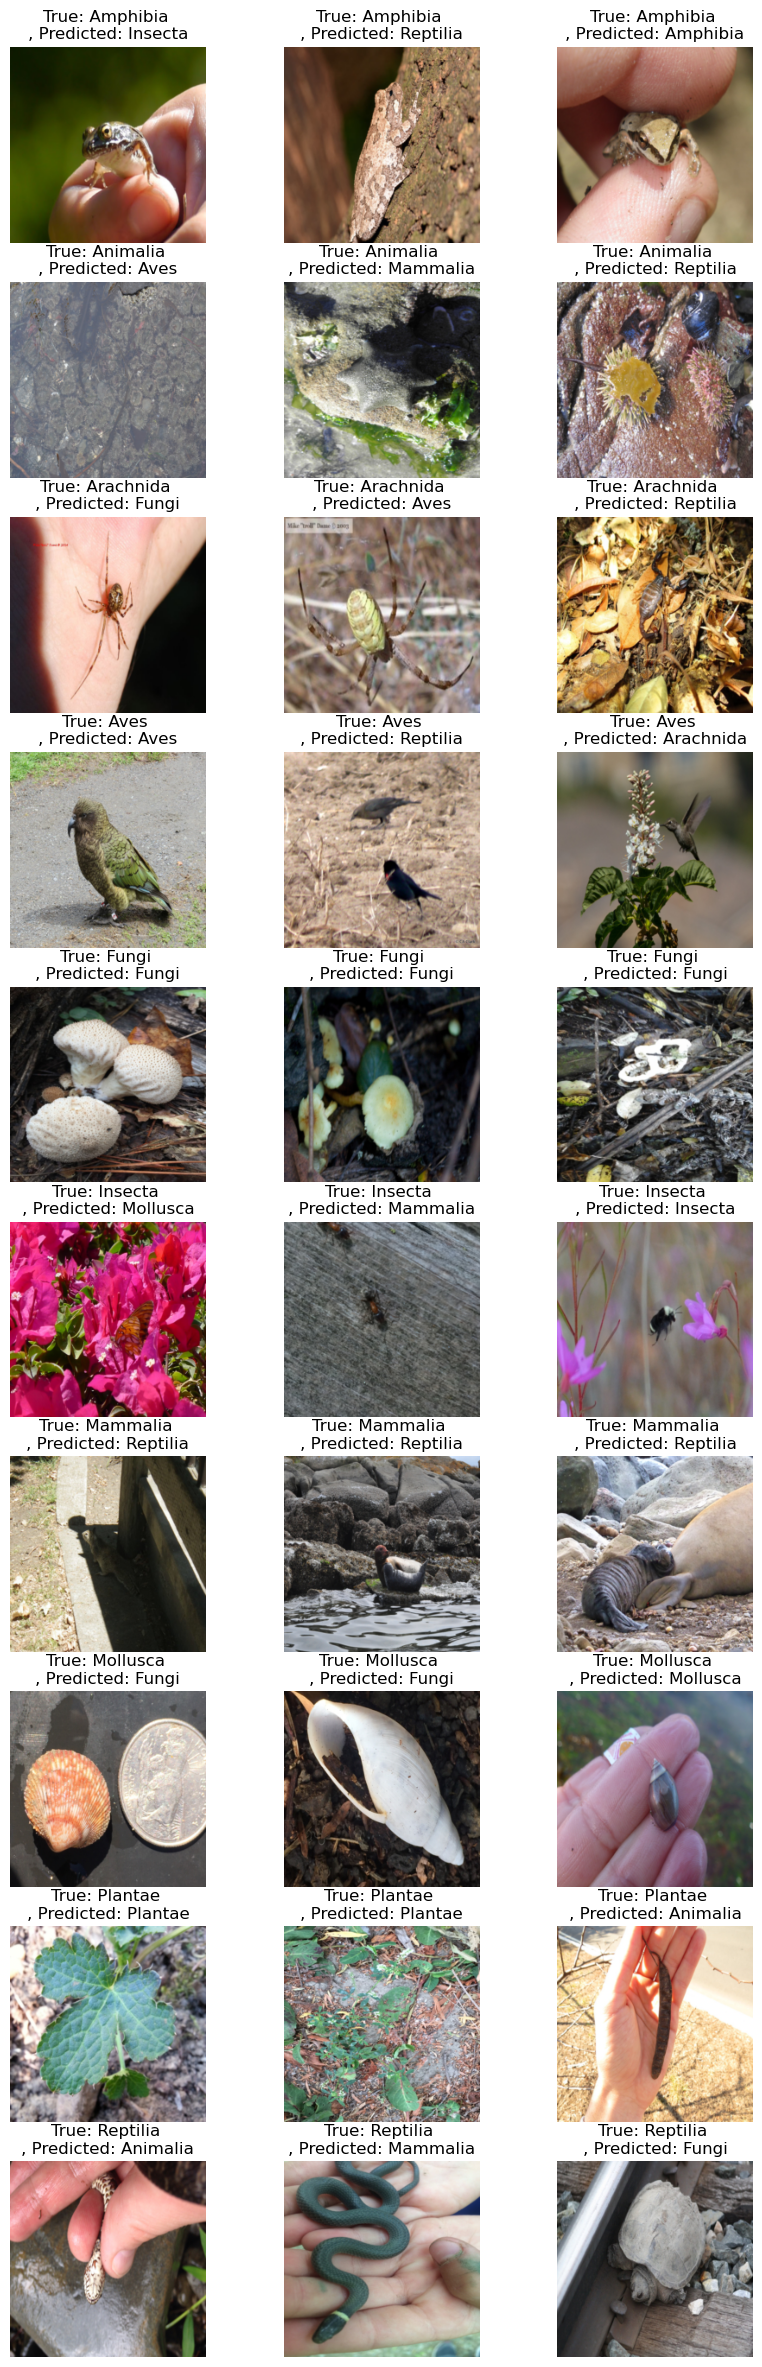

In [22]:
def predict_images():
    """
    Randomly select and predict images from the test dataset using the trained model,
    and display the images along with their true and predicted labels.

    This function creates a grid layout with 10 rows and 3 columns to display 3 images
    from each of the 10 classes in the test dataset.
    """

    # Create the grid layout
    fig, axes = plt.subplots(10, 3, figsize=(10, 30))
    
    for label in range(10):
        class_indices = np.where(y_test==label)[0]
        # randomly select sample_per_class_val indices for validation
        indices = np.random.choice(class_indices, 3, replace=False)
        
        for i in range(len(indices)):
            input_tensor = torch.from_numpy(X_test[indices[i]]).unsqueeze(0)  # Add a batch dimension
            input_tensor = input_tensor.to(device)
            # Now you can pass the input tensor through your model
            output = model(input_tensor)
            
            y_pred = output.argmax(dim=1)
            y_pred = y_pred.to("cpu")
            
            # Convert the tensor to a NumPy array
            y_pred = y_pred.detach().numpy()
            
            # Plot the image
            ax = axes[label, i]
            
            image = X_test[indices[i]]
            # Transpose the image array from (channels, height, width) to (height, width, channels) for Matplotlib
            image = np.transpose(image, (1, 2, 0))

            # Display the image using Matplotlib
            ax.imshow(image)
            ax.set_title(f"True: {class_names[y_test[indices[i]]]} \n, Predicted: {class_names[y_pred[0]]}")
            ax.axis('off')  # Turn off axis labels  
            
predict_images()